In [1]:
pip install spectres

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('/home/raghav/sunbather2/src') #add your path to /sunbather/src/ here

#import sunbather modules
import tools
import RT

#import other modules
import pandas as pd
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.stats as sps
import traceback
from scipy.optimize import curve_fit
import spectres #to resample synthetic spectra to the wavelength grid of observations (pip install spectres)
#for interactive matplotlib plots
%matplotlib widget

/home/raghav/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
### Useful functions ###

def get_xyz(df):
    '''
    Takes as input a Pandas DataFrame which has the x-values
    as the index, and the y-values as the column names,
    and the z-values as the dataframe contents.
    Returns three 1D arrays with the x, y, z values 
    that can e.g. be plotted with matplotlib tricontour.
    '''
    
    stacked_data = df.stack()
    stacked_data = stacked_data.dropna()
    x_values = stacked_data.index.get_level_values(0).tolist()  # x-values
    y_values = stacked_data.index.get_level_values(1).tolist()  # y-values
    z_values = stacked_data.tolist()  # z-values    
    
    return x_values, y_values, z_values


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    '''
    Cuts a colormap to a smaller range.
    from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    '''

    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def get_array_from_contour(cn, levelnum):
    '''
    Takes an ax.contour object and returns the 'levelnum'-th contour as an
    array of x and y values. You can then extract the min/max values from
    such a contour/array.
    '''
    
    lines = []
    for line in cn.collections[levelnum].get_paths():
        lines.append(line.vertices)

    if lines:
        x = np.concatenate(lines, axis=0)[:,0]
        y = np.concatenate(lines, axis=0)[:,1]
    else:
        print("No 1 sigma contour could be found")
        x, y = None, None

    return x, y


### Functions that calculate statistics ###

def calc_chisqs_He10830(Tstrucpath, observed_wavs, observed_ea, observed_sig_ea,
                        instrument_R=None,
                        T0low=2000, T0up=12000, T0step=100,
                        Mdotlow=8, Mdotup=12, Mdotstep=0.05,
                        **kwargs):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the metastable helium line, compares it to the observed
    profile and calculates the chi-squared value.
    Expects excess absorption and error in units of %.
    '''

    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0
    
    chisqs = pd.DataFrame(columns=Mdots, index=T0s, dtype=float)

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                #read in the converged simulation for this combination of T0 and Mdot by specifying the path
                sim = tools.Sim(Tstrucpath+'parker_'+T0+'_'+Mdot+'/converged')
                #we calculate the model spectrum on a high-resolution grid
                highres_wavs = np.linspace(10830, 10836, 100)
                FinFout, lines_found, lines_not_found = RT.FinFout(sim, highres_wavs, 'He', **kwargs)
                #convert to excess absorption in units of %
                model_excess_absorption = (np.max(FinFout) - FinFout) * 100
                #convolve with instrumental resolution, if any was passed
                if instrument_R is not None:
                    model_excess_absorption = RT.convolve_spectrum_R(highres_wavs, model_excess_absorption, instrument_R) #careful - it gets the same variable name
                #resample model to the observed wav points
                model_excess_absorption_ondata = spectres.spectres(observed_wavs, highres_wavs, model_excess_absorption, fill=0., verbose=False)
                #calculate chi squared
                chisq = np.sum(((model_excess_absorption_ondata - observed_ea) / observed_sig_ea)**2)
                #save chisq value in the pandas dataframe
                chisqs.loc[T0,Mdot] = chisq

            except FileNotFoundError as e: #then this Parker wind model was not calculated
                pass
            
            except Exception as e: #if something else went wrong
                traceback.print_exc()

    return chisqs


def calc_EWs_He10830(Tstrucpath, 
                     T0low=2000, T0up=12000, T0step=100,
                     Mdotlow=8, Mdotup=12, Mdotstep=0.05,
                     **kwargs):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the metastable helium line and integrates it to get the EW.
    '''

    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0
    
    model_EWs = pd.DataFrame(columns=Mdots, index=T0s, dtype=float)

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                #read in the converged simulation for this combination of T0 and Mdot by specifying the path
                sim = tools.Sim(Tstrucpath+'parker_'+T0+'_'+Mdot+'/converged')
                #set up the wavelength array in vacuum angstrom units
                wavs = np.logspace(np.log10(10831), np.log10(10835), num=100)
                #run the radiative transfer (to check if all lines were calculated, print lines_found)
                FinFout, lines_found, lines_not_found = RT.FinFout(sim, wavs, 'He', **kwargs)
                #convert from Fin/Fout to excess absorption - this assumes we reach the continuum somewhere
                absorption = np.max(FinFout) - FinFout
                #integrate to get EW
                EW = trapezoid(absorption, x=wavs)
                #save EW value in the pandas dataframe
                model_EWs.loc[T0,Mdot] = EW
                
            except FileNotFoundError as e: #then this Parker wind model was not calculated
                pass
            
            except Exception as e: #if something else went wrong
                traceback.print_exc()

    return model_EWs


def metaHe_weighted_T(sim):
    '''
    Calculates the mean temperature and its standard devation of the atmosphere weighted by
    the metastable helium number density (Eq. 4 & 5 in Linssen et al. 2022).
    '''
    
    #in Cloudy, not all bins have the same thickness, so we must compensate for that to do a fair weighting
    bin_thickness = np.diff(np.insert(sim.den.depth.values, 0, 0.))
    #the metastable helium state is the second lowest energy level and thus stored in the He[2] column of the density file
    T_He = np.sum(sim.ovr.Te.values * sim.den['He[2]'].values * bin_thickness) / np.sum(sim.den['He[2]'].values * bin_thickness)
    sigmaT = np.sqrt( np.sum(sim.den['He[2]'].values * bin_thickness * (sim.ovr.Te.values - T_He)**2) / np.sum(sim.den['He[2]'].values * bin_thickness) )
    
    return T_He, sigmaT


def calc_dT_helium(Tstrucpath,
            T0low=2000, T0up=12000, T0step=100,
            Mdotlow=8, Mdotup=12, Mdotstep=0.05):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the mean temperature weighted by the metastable helium density
    and its standard deviation. Calculates the temperature difference between
    the isothermal value and the He-weighted value, which can be used as 
    a measure of model self-consistency.
    '''
    
    Mdots = ["%.3f" % Mdot for Mdot in np.arange(Mdotlow, Mdotup+1e-5, Mdotstep)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(T0low, T0up+1e-5, T0step)] #set up a grid of T_0

    T_He = pd.DataFrame(columns=Mdots, index=T0s, dtype=float) #stores the weighted T
    sigmaT = T_He.copy() #stores standard deviation of T(r) around T_He
    dT = T_He.copy() #stores T_He - isothermal T

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                sim = tools.Sim(Tstrucpath+'/parker_'+T0+'_'+Mdot+'/converged') #load the converged simulation
                ClT, ClsigmaT = metaHe_weighted_T(sim) #find the T_He and sigT_He for this simulation
                T_He[Mdot][T0] = ClT
                sigmaT[Mdot][T0] = ClsigmaT
                dT[Mdot][T0] = ClT - int(T0)

            except FileNotFoundError: #then this profile was not calculated
                pass
            
    return dT, sigmaT


### Functions that calculate the Bayesian terms ###

def calc_likelihood_resolved(chisq_fit):
    '''
    Calculates the likelihood of a spectrally resolved fit to data,
    based on the chi-squared value.

    See e.g. https://philuttley.github.io/statistical-inference/10-mle_model_fitting/index.html
    for how the chi-squared statistic relates to the likelihood.
    '''

    likelihood = np.exp(-chisq_fit.values / 2.)

    likelihood = pd.DataFrame(columns=chisq_fit.columns.values, index=chisq_fit.index.values, 
                             data=likelihood, dtype=float) #turn into pd.DataFrame
    
    return likelihood


def calc_likelihood_unresolved(nsig_fit):
    '''
    Calculates the likelihood of spectrally unresolved data,
    expects a pandas dataframe that stores the number of 
    errorbars difference between model and data.
    '''

    likelihood = sps.norm.pdf(nsig_fit.abs())

    likelihood = pd.DataFrame(columns=nsig_fit.columns.values, index=nsig_fit.index.values, 
                             data=likelihood, dtype=float) #turn into pd.DataFrame
    
    return likelihood


def calc_prior(dT, sigmaT):
    '''
    Calculates a prior based on the model temperature self-consistency.
    See Linssen et al. (2022) for details on the choice of prior evaluation.
    '''

    #check that dT and sigmaT are defined on the same T-Mdot grid
    assert np.array_equal(dT.index.values, sigmaT.index.values), "Different temperature grids."
    assert np.array_equal(dT.columns.values, sigmaT.columns.values), "Different mass-loss rate grids."

    T0grid = dT.index.values.astype(float)
    Mdotgrid = dT.columns.values.astype(float)

    #assume prior is a normal distribution around dT=0 with std dev sigmaT
    number_sigma = dT / sigmaT
    prior = sps.norm.pdf(number_sigma)
    #now normalize the prior
    prior[np.isnan(prior)] = 0.
    prior_sum = trapezoid(trapezoid(prior, axis=1, x=Mdotgrid), x=T0grid)
    prior = prior / prior_sum

    prior = pd.DataFrame(columns=dT.columns.values, index=dT.index.values, 
                             data=prior, dtype=float) #turn into pd.DataFrame
    
    return prior


def calc_posterior(prior, likelihood):
    '''
    Combines the prior from the T0-T_He analysis with the likelihoods
    from the data fit with Bayes' theorem to calculate the posterior.
    '''

    if isinstance(prior, pd.DataFrame):
        #check that the prior and likelihoods are defined on the same T-Mdot grid
        assert np.array_equal(prior.index.values, likelihood.index.values), "Different temperature grids."
        assert np.array_equal(prior.columns.values, likelihood.columns.values), "Different mass-loss rate grids."

    T0grid = likelihood.index.values.astype(float)
    Mdotgrid = likelihood.columns.values.astype(float)

    integrand = prior*likelihood
    integrand[np.isnan(integrand)] = 0.
    evidence = trapezoid(trapezoid(integrand, axis=1, x=Mdotgrid), x=T0grid)
    posterior = integrand / evidence

    posterior = pd.DataFrame(columns=likelihood.columns.values, index=likelihood.index.values, 
                             data=posterior, dtype=float) #turn into pd.DataFrame


    #calculate marginalized posteriors
    post_Mdot = trapezoid(posterior.values, axis=0, x=T0grid)
    post_T0 = trapezoid(posterior.values, axis=1, x=Mdotgrid)

    post_Mdot_cum = cumulative_trapezoid(post_Mdot, x=Mdotgrid)
    lowsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.16)]
    mid_Mdot = Mdotgrid[np.argmin(np.abs(post_Mdot_cum - 0.5)) + 1]
    upsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.84) + 1]
    print("Constraints from marginalized posteriors (not necessarily normally distributed!):")
    print(f"log10(Mdot) = {mid_Mdot} + {upsig_Mdot-mid_Mdot} - {mid_Mdot-lowsig_Mdot}")

    post_T0_cum = cumulative_trapezoid(post_T0, x=T0grid)
    lowsig_T0 = T0grid[np.argmax(post_T0_cum > 0.16)]
    mid_T0 = T0grid[np.argmin(np.abs(post_T0_cum - 0.5)) + 1]
    upsig_T0 = T0grid[np.argmax(post_T0_cum > 0.84) + 1]
    print(f"T0 = {mid_T0} + {upsig_T0-mid_T0} - {mid_T0-lowsig_T0}")


    return posterior


### Functions that plot stuff ###

def plot_chisq_fit(chisq_fit,
                   dof=None, bounds_T0=None, bounds_Mdot=None,
                   title=None, save=None, fig=None, ax=None):
    '''
    Makes a standard plot of the Parker wind models fitted to the data.
    In this case, we fit the resolved line shape, and
    the colormap shows the chi squared statistic.
    '''

    pixT = float(chisq_fit.index[1])-float(chisq_fit.index[0]) #T step size
    pixM = float(chisq_fit.columns[1]) - float(chisq_fit.columns[0]) #Mdot step size

    if dof != None: #then we assume you want to plot the reduced chi squared
        plotted_vals = chisq_fit / dof
        cbar_label = r'Reduced $\chi ^2$'
    else:
        plotted_vals = chisq_fit
        cbar_label = r'$\chi ^2$'

    
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(plotted_vals.T, cmap='Blues_r', norm=matplotlib.colors.LogNorm(), 
                    origin='lower', aspect='auto', interpolation='none',
                    extent=[float(chisq_fit.index[0])-0.5*pixT, float(chisq_fit.index[-1])+0.5*pixT, 
                              float(chisq_fit.columns[0])-0.5*pixM, float(chisq_fit.columns[-1])+0.5*pixM])
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=cbar_label)
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()


def plot_nsig_fit(nsig_fit, bounds_T0=None, bounds_Mdot=None,
             title=None, save=None, fig=None, ax=None):
    '''
    Makes a standard plot of the Parker wind models fitted to the data.
    In this case, we fit the EW of the model to the EW of the data, and
    the colormap simply indicates how many data errorbars difference there is.
    '''
    
    cmap = plt.get_cmap('Blues_r')
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=5)

    pixT = float(nsig_fit.index[1]) - float(nsig_fit.index[0]) #T step size
    pixM = float(nsig_fit.columns[1]) - float(nsig_fit.columns[0]) #Mdot step size

    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(nsig_fit.T.abs(), cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(nsig_fit.index[0])-0.5*pixT, float(nsig_fit.index[-1])+0.5*pixT, 
                              float(nsig_fit.columns[0])-0.5*pixM, float(nsig_fit.columns[-1])+0.5*pixM])
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=r'$\Delta\sigma$')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()


def plot_selfcons(dT, sigmaT,
                  bounds_T0=None, bounds_Mdot=None,
                  title=None, fig=None, ax=None):
    '''
    Makes a standard plot of the self-consistency of the Parker wind parameter space.
    Self-consistent models are white, while blue/red models indicate models for which
    Cloudy indicates that the temperature in the helium line-forming region is
    cooler/hotter than that assumed in creating the isothermal profiles, respectively.
    The dotted lines indicate 1 standard deviation discrepancy. 
    '''
    
    cmap = truncate_colormap(plt.get_cmap('seismic'), 0.2, 0.8)
    normalize = matplotlib.colors.Normalize(vmin=-4000, vmax=4000)

    pixT = float(dT.index[1])-float(dT.index[0]) #T step size
    pixM = float(dT.columns[1]) - float(dT.columns[0]) #Mdot step size

    
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False

    im = ax.imshow(dT.T, cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(dT.index[0])-0.5*pixT, float(dT.index[-1])+0.5*pixT, 
                              float(dT.columns[0])-0.5*pixM, float(dT.columns[-1])+0.5*pixM])
    #plot the 1 sigma line (i.e. dT = sigmaT)
    sig1lines = ax.contour(dT.index.astype(float), dT.columns.astype(float), (dT / sigmaT).T, 
                           levels=[-1,1], zorder=1, colors='black', linestyles='dotted')
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    fig.colorbar(im, label=r'$T_{He} - T_0$ [K]')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if _showplot:
        plt.show()


def plot_posterior(posterior,
                   bounds_T0=None, bounds_Mdot=None,
                   title=None, save=None, log=False):
    '''
    Plots the posterior distribution and the marginalized distributions.
    Prints the 1 sigma confidence intervals, at the precision of the T0/Mdot-grid.
    '''

    T0grid = posterior.index.values.astype(float)
    Mdotgrid = posterior.columns.values.astype(float)
    post = posterior.values
    
    pixT = np.diff(T0grid)[0] #T step size
    pixM = np.diff(Mdotgrid)[0] #Mdot step size

    #calculate marginalized posteriors
    post_Mdot = trapezoid(post, axis=0, x=T0grid)
    post_T0 = trapezoid(post, axis=1, x=Mdotgrid)

    post_Mdot_cum = cumulative_trapezoid(post_Mdot, x=Mdotgrid)
    lowsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.16)]
    mid_Mdot = Mdotgrid[np.argmin(np.abs(post_Mdot_cum - 0.5)) + 1]
    upsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.84) + 1]

    post_T0_cum = cumulative_trapezoid(post_T0, x=T0grid)
    lowsig_T0 = T0grid[np.argmax(post_T0_cum > 0.16)]
    mid_T0 = T0grid[np.argmin(np.abs(post_T0_cum - 0.5)) + 1]
    upsig_T0 = T0grid[np.argmax(post_T0_cum > 0.84) + 1]


    fig = plt.figure(figsize=(5, 5))
    gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_T0 = fig.add_subplot(gs[0, 0])
    ax_Mdot = fig.add_subplot(gs[1, 1])

    im = ax.imshow(post.T, cmap=plt.get_cmap('Greys'), origin='lower', aspect='auto', interpolation='none',
                extent=[T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT, 
                        Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM])
    if log:
        im.set_norm(matplotlib.colors.LogNorm())
    ax_T0.plot(T0grid, post_T0, color='k')
    ax_Mdot.plot(post_Mdot, Mdotgrid, color='k')


    ax_T0.axvline(mid_T0, color='blue', linewidth=0.7)
    ax_T0.axvline(lowsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_T0.axvline(upsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(mid_Mdot, color='blue', linewidth=0.7)
    ax_Mdot.axhline(lowsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(upsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')

    ax_T0.set_xticks([])
    ax_T0.set_yticks([])
    ax_Mdot.set_xticks([])
    ax_Mdot.set_yticks([])

    ax.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax_T0.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    ax_Mdot.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    if bounds_T0 != None:
        ax_T0.set_xlim(*bounds_T0)
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax_Mdot.set_ylim(*bounds_Mdot)
        ax.set_ylim(*bounds_Mdot)

    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if title != None:
        ax_T0.set_title(title)

    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    plt.show()


def plot_joint_constraint_resolved(dT, sigmaT, chisq_fit, posterior, 
                                   bounds_T0=None, bounds_Mdot=None, 
                                   title=None, save=None, fig=None, ax=None, 
                                   post_uptosigma=1, cmap_T=None,
                                  cmap_fit=None, show_colorbar=True):
    '''
    Makes a standard plot of the posterior distribution, 
    on top of the prior (self-consistency) and likelihood (data fit) constraints.
    Also prints out the 1sigma bounds on T and Mdot.

    chisq_fit must be given, but dT, sigmaT and posterior can be passed as None
    if they should not be plotted.
    '''

    assert post_uptosigma <=3, "Maximum value of post_uptosigma is 3"

    if cmap_T is None:
        cmap_T = truncate_colormap(plt.get_cmap('autumn'), 0.35, 0.65)
    if cmap_fit is None:
        cmap_fit = truncate_colormap(plt.get_cmap('winter_r'), 0.35, 0.65)
    

    if fig == None and ax == None:
        showplot = True
        fig, ax = plt.subplots(1)
    else:
        showplot = False
    
    #### Plot the model temperature discrepancy (i.e. prior)
    if dT is not None and sigmaT is not None:
        nsig_T = dT / sigmaT

        x, y, z = get_xyz(nsig_T)

        ax.tricontour(x, y, z, cmap=cmap_T, levels=[0], zorder=0) #plots the orange line
        prior_contour = ax.tricontourf(x, y, np.abs(z), cmap=cmap_T, levels=[0,1,2], alpha=0.5, zorder=0) #plots the orange contours
    
    
    #### Plot the fit constraints (i.e. likelihood):
    likelihood = calc_likelihood_resolved(chisq_fit)
    likelihood = likelihood.fillna(0.)
    highest_likelihood = likelihood.max().max()
    sigma1_likelihood = highest_likelihood * np.exp(-1/2)
    sigma2_likelihood = highest_likelihood * np.exp(-4/2)
    sigma3_likelihood = highest_likelihood * np.exp(-9/2)
    
    x, y, z = get_xyz(likelihood)
    
    likelihood_contour = ax.tricontourf(x, y, z, cmap=cmap_fit, levels=[sigma2_likelihood, sigma1_likelihood, highest_likelihood], alpha=0.5, zorder=1) #plots the blue contours
    
    
    #### Plot the posterior
    if posterior is not None and post_uptosigma > 0:
        #calculate the posterior values that corresponds to the 1,2,3 sigma contours
        posterior_sorted = np.sort(posterior.values.flatten())[::-1]
        posterior_sum = np.sum(posterior_sorted)
        posterior_cumsum = np.cumsum(posterior_sorted)
        p1sigma = posterior_sorted[posterior_cumsum > 0.3935 * posterior_sum][0]
        p2sigma = posterior_sorted[posterior_cumsum > 0.8647 * posterior_sum][0]
        p3sigma = posterior_sorted[posterior_cumsum > 0.9889 * posterior_sum][0]
        post_levels = [p3sigma, p2sigma, p1sigma][3-post_uptosigma:]
        post_linestyles = ['dotted', 'dashed', 'solid'][3-post_uptosigma:]

        x, y, z = get_xyz(posterior)
        
        #plot the joint posterior 1/2/3 sigma lines:
        cn_post = ax.tricontour(x, y, z, levels=post_levels, linestyles=post_linestyles, colors='black', zorder=2)
        
        #print the posterior 1sigma credible intervals:
        pT0, pMdot = get_array_from_contour(cn_post, -1) #get last level (=1 sigma) from posterior
        if pT0 is not None and pMdot is not None:
            bestT0_index, bestMdot_index = np.unravel_index(np.nanargmax(posterior), posterior.shape)
            bestT0, bestMdot = float(posterior.index[bestT0_index]), float(posterior.columns[bestMdot_index]) #T, Mdot of the maximum of the posterior
            max_pMdot, min_pMdot, max_pT0, min_pT0 = np.max(pMdot), np.min(pMdot), np.max(pT0), np.min(pT0) #
            print(f"1 sigma constraints:\nlog10(Mdot) = {bestMdot} + {max_pMdot-bestMdot} - {bestMdot-min_pMdot}")
            print(f"T0 = {bestT0} + {max_pT0-bestT0} - {bestT0-min_pT0}")
    
    
    if show_colorbar:
        divider = make_axes_locatable(ax)
        
        if dT is not None and sigmaT is not None:
            #plot the prior colorbar
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            cbar1 = fig.colorbar(prior_contour, cax=cax1)
            cax1.yaxis.set_major_locator(plt.NullLocator()) #turn the ticks for cbar1 off
        
        #plot the likelihood colorbar    
        cax2 = divider.append_axes("right", size="5%", pad=0.05)
        cbar2 = fig.colorbar(likelihood_contour, cax=cax2)
        cax2.set_yticklabels([r'2$\sigma$', r'1$\sigma$', r'0$\sigma$'])
        cax2.invert_yaxis() #because the p-values and sigma values are in opposite direction

        
    
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if bounds_T0:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot:
        ax.set_ylim(*bounds_Mdot)
        ax.set_yticks(np.arange(bounds_Mdot[0], bounds_Mdot[1] + 0.5, 0.5))
    if title != None:
        ax.set_title(title)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if showplot:
        plt.show()


def plot_joint_constraint_unresolved(dT, sigmaT, nsig_fit, posterior, 
                                     bounds_T0=None, bounds_Mdot=None, 
                                     title=None, save=None, 
                                     fig=None, ax=None, cmap_T=None,
                                    cmap_fit=None, post_uptosigma=1,
                                    show_colorbar=True):
    '''
    Makes a plot of the 1sigma posterior contour 
    on top of the prior (self-consistency) and likelihood (data fit) constraints.
    Also prints out the 1sigma bounds on T and Mdot, which are calculated
    based on the matplotlib contour, and thus involve interpolation to
    higher precision than the data itself.
    '''

    assert post_uptosigma <=3, "Maximum value of post_uptosigma is 3"

    if cmap_T is None:
        cmap_T = truncate_colormap(plt.get_cmap('autumn'), 0.35, 0.65)
    if cmap_fit is None:
        cmap_fit = truncate_colormap(plt.get_cmap('winter'), 0.35, 0.65)

     
    if fig == None and ax == None:
        _showplot = True
        fig, ax = plt.subplots(1)
    else:
        _showplot = False
    
    #### Plot the model temperature discrepancy (i.e. prior)
    if dT is not None and sigmaT is not None:
        nsig_T = dT / sigmaT

        x, y, z = get_xyz(nsig_T)

        ax.tricontour(x, y, z, cmap=cmap_T, levels=[0], zorder=0) #plots the orange line
        prior_contour = ax.tricontourf(x, y, np.abs(z), cmap=cmap_T, levels=[0,1,2], alpha=0.5, zorder=0) #plots the orange contours
    
    #### Plot the fit constraints (i.e. likelihood):
    x, y, z = get_xyz(nsig_fit)
    ax.tricontour(x, y, z, cmap=cmap_fit, levels=[0], zorder=1) #plots the blue line
    likelihood_contour = ax.tricontourf(x, y, np.abs(z), cmap=cmap_fit, levels=[0,1,2], alpha=0.5, zorder=1) #plots the blue contours
    
    #### Plot the posterior
    if posterior is not None and post_uptosigma > 0:
        #calculate the posterior values that corresponds to the 1,2,3 sigma contours
        posterior_sorted = np.sort(posterior.values.flatten())[::-1]
        posterior_sum = np.sum(posterior_sorted)
        posterior_cumsum = np.cumsum(posterior_sorted)
        p1sigma = posterior_sorted[posterior_cumsum > 0.3935 * posterior_sum][0]
        p2sigma = posterior_sorted[posterior_cumsum > 0.8647 * posterior_sum][0]
        p3sigma = posterior_sorted[posterior_cumsum > 0.9889 * posterior_sum][0]
        post_levels = [p3sigma, p2sigma, p1sigma][3-post_uptosigma:]
        post_linestyles = ['dotted', 'dashed', 'solid'][3-post_uptosigma:]

        x, y, z = get_xyz(posterior)

        #plot the joint posterior 1/2/3 sigma lines:
        cn_post = ax.tricontour(x, y, z, levels=post_levels, linestyles=post_linestyles, colors='black', zorder=2)
        
        #print the posterior 1sigma credible intervals:
        pT0, pMdot = get_array_from_contour(cn_post, -1) #get last level (=1 sigma) from posterior
        if pT0 is not None and pMdot is not None:
            bestT0_index, bestMdot_index = np.unravel_index(np.nanargmax(posterior), posterior.shape)
            bestT0, bestMdot = float(posterior.index[bestT0_index]), float(posterior.columns[bestMdot_index]) #T, Mdot of the maximum of the posterior
            max_pMdot, min_pMdot, max_pT0, min_pT0 = np.max(pMdot), np.min(pMdot), np.max(pT0), np.min(pT0) #
            print(f"1 sigma constraints:\nlog10(Mdot) = {bestMdot} + {max_pMdot-bestMdot} - {bestMdot-min_pMdot}")
            print(f"T0 = {bestT0} + {max_pT0-bestT0} - {bestT0-min_pT0}")
    
    
    if show_colorbar:
        divider = make_axes_locatable(ax)
        
        if dT is not None and sigmaT is not None:
            #plot the prior colorbar
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            cbar1 = fig.colorbar(prior_contour, cax=cax1)
            cax1.yaxis.set_major_locator(plt.NullLocator()) #turn the ticks for cbar1 off
        
        #plot the likelihood colorbar    
        cax2 = divider.append_axes("right", size="5%", pad=0.05)
        cbar2 = fig.colorbar(likelihood_contour, cax=cax2)
        cax2.set_yticklabels([r'0$\sigma$', r'1$\sigma$', r'2$\sigma$'])
    
    
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if bounds_T0:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot:
        ax.set_ylim(*bounds_Mdot)
        ax.set_yticks(np.arange(bounds_Mdot[0], bounds_Mdot[1] + 0.5, 0.5))
    if title != None:
        ax.set_title(title)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=300)
    if _showplot:
        plt.show()

In [4]:
'''def plot_HeSpec(filename):
    #set random seed for consistent results
    np.random.seed(0)
    """
    #if due to a different numpy version, your generated mock spectrum is different,
    #our generated mock spectrum can be found in 'materials/hotNeptune_helium_mock_spectrum.txt',
    #which has stored np.column_stack((wavs, observed_excess_absorption, observed_excess_absorption_errorbar))
    """
    
    #Let's make the spectrum of the generic hot Neptune
    hotNep = tools.Sim(tools.projectpath+filename)
    
    wavs = RT.constantR_wavs(10830, 10836, 80000)
    true_spec, _, _ = RT.FinFout(hotNep, wavs, 'He')
    #wavs = RT.constantR_wavs(6558, 6568, 80000)
    #true_spec, _, _ = RT.FinFout(hotNep, wavs, 'H')
    
    #draw errors from normal distribution
    observed_errorbar = np.ones_like(wavs) * 0.0025 #just pick a number
    observed_spec = np.random.normal(loc=true_spec, scale=observed_errorbar)
    
    #convert into excess absorption in % which is what the calc_chisqs_He10830() function expects
    #we pretend we don't know the continuum level and take it as the average away from the line (last 15 points)
    observed_excess_absorption = 100 * (np.mean(observed_spec[-15:]) - observed_spec)
    observed_excess_absorption_errorbar = 100 * observed_errorbar
    
    highres_wavs = np.linspace(10830, 10836, 1000) #for smooth plotting
    highres_true_spec, _, _ = RT.FinFout(hotNep, highres_wavs, 'He')
    #highres_true_spec, _, _ = RT.FinFout(hotNep, highres_wavs, 'H')
    #highres_wavs = np.linspace(6558, 6568, 1000)
    
    fig, ax = plt.subplots(1)
    ax.plot(highres_wavs, highres_true_spec)
    ax.errorbar(wavs, observed_spec, yerr=observed_errorbar, fmt='o')
    ax.set_xlabel("Wavelength [Å]")
    ax.set_ylabel(r"$F_{in}$/$F_{out}$")
    plt.show()
    
    
    #integrate the difference with the continuum to obtain the equivalent width
    true_EW = trapezoid(np.max(true_spec) - true_spec, x=wavs) #units: Å
    #let's choose the errorbar as 1/8 of the EW so that we will get around a 8 sigma detection
    observed_EW_errorbar = true_EW / 8.
    observed_EW = np.random.normal(loc=true_EW, scale=observed_EW_errorbar)
    print(f"The true EW is {true_EW}. We have drawn an observed EW = {observed_EW} +- {observed_EW_errorbar} " \
          f"(which is a {observed_EW/observed_EW_errorbar} sigma detection)")
    
    print("The EW here is",true_EW/0.016535145134224084*100,'% of constant abundance atmosphere' )
'''

'def plot_HeSpec(filename):\n    #set random seed for consistent results\n    np.random.seed(0)\n    """\n    #if due to a different numpy version, your generated mock spectrum is different,\n    #our generated mock spectrum can be found in \'materials/hotNeptune_helium_mock_spectrum.txt\',\n    #which has stored np.column_stack((wavs, observed_excess_absorption, observed_excess_absorption_errorbar))\n    """\n    \n    #Let\'s make the spectrum of the generic hot Neptune\n    hotNep = tools.Sim(tools.projectpath+filename)\n    \n    wavs = RT.constantR_wavs(10830, 10836, 80000)\n    true_spec, _, _ = RT.FinFout(hotNep, wavs, \'He\')\n    #wavs = RT.constantR_wavs(6558, 6568, 80000)\n    #true_spec, _, _ = RT.FinFout(hotNep, wavs, \'H\')\n    \n    #draw errors from normal distribution\n    observed_errorbar = np.ones_like(wavs) * 0.0025 #just pick a number\n    observed_spec = np.random.normal(loc=true_spec, scale=observed_errorbar)\n    \n    #convert into excess absorption in % whic

In [5]:
'''#set random seed for consistent results
np.random.seed(0)
"""
#if due to a different numpy version, your generated mock spectrum is different,
#our generated mock spectrum can be found in 'materials/hotNeptune_helium_mock_spectrum.txt',
#which has stored np.column_stack((wavs, observed_excess_absorption, observed_excess_absorption_errorbar))
"""

#Let's make the spectrum of the generic hot Neptune
hotNep = tools.Sim(tools.projectpath+filename)

wavs = RT.constantR_wavs(10830, 10836, 80000)
true_spec, _, _ = RT.FinFout(hotNep, wavs, 'He')

#draw errors from normal distribution
observed_errorbar = np.ones_like(wavs) * 0.0025 #just pick a number
observed_spec = np.random.normal(loc=true_spec, scale=observed_errorbar)

#convert into excess absorption in % which is what the calc_chisqs_He10830() function expects
#we pretend we don't know the continuum level and take it as the average away from the line (last 15 points)
observed_excess_absorption = 100 * (np.mean(observed_spec[-15:]) - observed_spec)
observed_excess_absorption_errorbar = 100 * observed_errorbar

highres_wavs = np.linspace(10830, 10836, 1000) #for smooth plotting
highres_true_spec, _, _ = RT.FinFout(hotNep, highres_wavs, 'He')

#integrate the difference with the continuum to obtain the equivalent width
true_EW = trapezoid(np.max(true_spec) - true_spec, x=wavs) #units: Å
#let's choose the errorbar as 1/8 of the EW so that we will get around a 8 sigma detection
observed_EW_errorbar = true_EW / 8.
observed_EW = np.random.normal(loc=true_EW, scale=observed_EW_errorbar)
#print(f"The true EW is {true_EW}. We have drawn an observed EW = {observed_EW} +- {observed_EW_errorbar} " \
      f"(which is a {observed_EW/observed_EW_errorbar} sigma detection)")

#print("The EW here is",true_EW/0.016535145134224084*100,'% of constant abundance atmosphere' )
return highres_wavs,highres_true_spec,wavs,observed_errorbar,observed_spec'''

'#set random seed for consistent results\nnp.random.seed(0)\n"""\n#if due to a different numpy version, your generated mock spectrum is different,\n#our generated mock spectrum can be found in \'materials/hotNeptune_helium_mock_spectrum.txt\',\n#which has stored np.column_stack((wavs, observed_excess_absorption, observed_excess_absorption_errorbar))\n"""\n\n#Let\'s make the spectrum of the generic hot Neptune\nhotNep = tools.Sim(tools.projectpath+filename)\n\nwavs = RT.constantR_wavs(10830, 10836, 80000)\ntrue_spec, _, _ = RT.FinFout(hotNep, wavs, \'He\')\n\n#draw errors from normal distribution\nobserved_errorbar = np.ones_like(wavs) * 0.0025 #just pick a number\nobserved_spec = np.random.normal(loc=true_spec, scale=observed_errorbar)\n\n#convert into excess absorption in % which is what the calc_chisqs_He10830() function expects\n#we pretend we don\'t know the continuum level and take it as the average away from the line (last 15 points)\nobserved_excess_absorption = 100 * (np.mean(o

In [6]:
basepath = "/home/raghav/project_sb/sims/"
def atmabundance(filename):
    depths = []
    abund = []
    flag = 0
    with open(basepath+filename) as f:
        for line in f:
            words = line.split()
            if(flag==1 and '#' not in words[0]):
                if('end' in words):
                    break
                depths.append(float(words[0]))
                abund.append(float(words[1]))
            if (words[0] =='#' and 'abundance' in words):
                next(f)
                flag = 1
    depth_array = np.array(depths)
    abund_array = np.array(abund)
    xp = depth_array[1:]
    fp = abund_array[1:]
    x = np.linspace(depth_array[1],depth_array[-1],1000)
    y = np.interp(x,xp,fp)
    #ticks_array = xp
    return x,y,xp,fp


In [7]:
def HeSpec(filename):
    
    hotNep = tools.Sim(tools.projectpath+filename)
    wavs = RT.constantR_wavs(10830,10836,80000)
    true_spec,_,_ = RT.FinFout(hotNep,wavs,'He')
    highres_wavs = np.linspace(10830,10836,1000)
    highres_true_spec,_,_ = RT.FinFout(hotNep,highres_wavs,'He')
    true_EW = trapezoid(np.max(true_spec)-true_spec, x= wavs)
    return highres_wavs,highres_true_spec

In [8]:
'''fig, ax = plt.subplots(1)
ax.plot(highres_wavs, highres_true_spec)
ax.errorbar(wavs, observed_spec, yerr=observed_errorbar, fmt='o')
ax.set_xlabel("Wavelength [Å]")
ax.set_ylabel(r"$F_{in}$/$F_{out}$")
plt.show()'''
    
    

'fig, ax = plt.subplots(1)\nax.plot(highres_wavs, highres_true_spec)\nax.errorbar(wavs, observed_spec, yerr=observed_errorbar, fmt=\'o\')\nax.set_xlabel("Wavelength [Å]")\nax.set_ylabel(r"$F_{in}$/$F_{out}$")\nplt.show()'

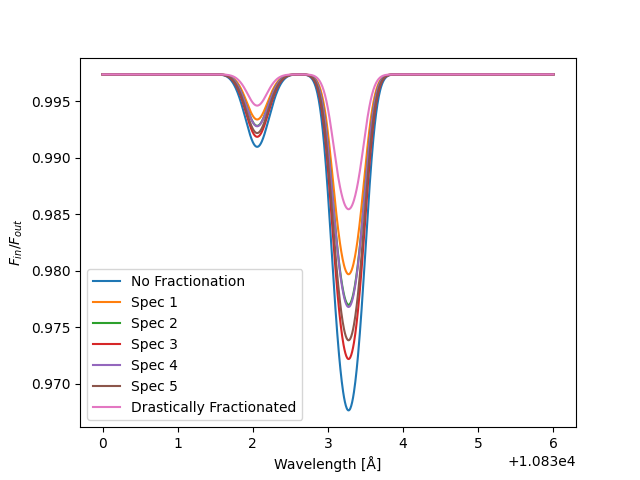

In [9]:
hw, hres_truespec_original = HeSpec("/sims/1D/hotNeptune/z_0_9/parker_5100_10.950/converged")
hw,hres_truespec_1 = HeSpec('/sims/HeDepthTest_5100_10.950/converged')   
hw,hres_truespec_2 = HeSpec('/sims/HeDepthTest_5100_10.950_2/converged')   
hw,hres_truespec_3 = HeSpec("/sims/HeDepthTest_5100_10.950_3/converged") 
hw,hres_truespec_4 = HeSpec('/sims/HeDepthTest_5100_10.950_4/converged') 
hw,hres_truespec_5 = HeSpec('/sims/HeDepthTest_5100_10.950_5/converged')   
hw,hres_truespec_frac = HeSpec('/sims/HeFrac/converged') 

fig,ax = plt.subplots(1)
ax.plot(hw,hres_truespec_original,label='No Fractionation')
ax.plot(hw,hres_truespec_1,label='Spec 1')
ax.plot(hw,hres_truespec_2,label='Spec 2')
ax.plot(hw,hres_truespec_3,label='Spec 3')
ax.plot(hw,hres_truespec_4,label='Spec 4')
ax.plot(hw,hres_truespec_5,label='Spec 5')
ax.plot(hw,hres_truespec_frac,label='Drastically Fractionated')
ax.set_xlabel("Wavelength [Å]")
ax.set_ylabel(r"$F_{in}$/$F_{out}$")
plt.legend()
plt.show()

**Plotting Fractionation**

In [10]:
x1,y1,xp1,fp1 = atmabundance('HeDepthTest_5100_10.950/converged.in')
x2,y2,xp2,fp2 = atmabundance('HeDepthTest_5100_10.950_2/converged.in')
x3,y3,xp3,fp3 = atmabundance('HeDepthTest_5100_10.950_3/converged.in')
x4,y4,xp4,fp4 = atmabundance('HeDepthTest_5100_10.950_4/converged.in')
x5,y5,xp5,fp5 = atmabundance('HeDepthTest_5100_10.950_5/converged.in')
x6,y6,xp6,fp6 = atmabundance('HeFrac/converged.in')
x = [x1,x2,x3,x4,x5,x6]
y = [y1,y2,y3,y4,y5,y6]
xp = [xp1,xp2,xp3,xp4,xp5,xp6]
fp = [fp1,fp2,fp3,fp4,fp5,fp6]
'''for xi,yi,xpi,fpi in zip(x,y,xp,fp):
    plt.plot(10**xi,10**yi)
    plt.scatter(10**xpi,10**fpi,color='red')'''
    #plt.legend()

"for xi,yi,xpi,fpi in zip(x,y,xp,fp):\n    plt.plot(10**xi,10**yi)\n    plt.scatter(10**xpi,10**fpi,color='red')"

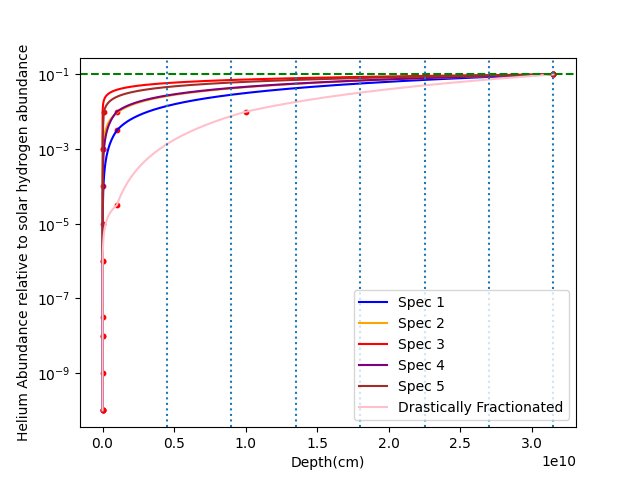

In [15]:
fig2,ax2 = plt.subplots(1)
ax2.plot(10**x1,10**y1,color='blue',label='Spec 1')
ax2.plot(10**x2,10**y2,color='orange',label='Spec 2')
ax2.plot(10**x3,10**y3,color='red',label='Spec 3')
ax2.plot(10**x4,10**y4,color='purple',label='Spec 4')
ax2.plot(10**x5,10**y5,color='brown',label='Spec 5')
ax2.plot(10**x6,10**y6,color='pink',label='Drastically Fractionated')
# ax2.scatter(10**xp1,10**fp1,color='red',s=10)
# ax2.scatter(10**xp2,10**fp2,color='red',s=10)
# ax2.scatter(10**xp3,10**fp3,color='red',s=10)
# ax2.scatter(10**xp4,10**fp4,color='red',s=10)
# ax2.scatter(10**xp5,10**fp5,color='red',s=10)
# ax2.scatter(10**xp6,10**fp6,color='red',s=10)
for xpi,fpi in zip(xp,fp):
    ax2.scatter(10**xpi,10**fpi,color='red',s=10)
ax2.axhline(0.1,color='green',linestyle='dashed')
for i in range(1,8):
    plt.axvline(i*0.45e10,linestyle='dotted')
#plt.xscale('log')
plt.yscale('log')
ax2.set_xlabel('Depth(cm)')
ax2.set_ylabel('Helium Abundance relative to solar hydrogen abundance')
#plt.xlim(10**2,10**10.4)
#plt.xlim(10**9,10**12)
#plt.yticks(ticks=ticks_array)
#plt.xticks(10**xp[0])
#plt.yticks(10**fp[0])
plt.legend()
plt.show()

In [12]:
Planet1 = tools.Planet('hotNeptune')

In [13]:
Planet1.print_params()

Name: hotNeptune
Full name: generic hot Neptune
Planet radius: 3574600000.0 cm, 0.5 RJ
Star radius: 69634000000.0 cm, 1.0 Rsun
Semi-major axis: 747989355000.0 cm, 0.05 AU
Planet mass: 1.898e+29 g, 0.1 MJ
Star mass: 1.9891e+33 g, 1.0 Msun
Transit impact parameter: 0.0 Rstar
Stellar spectrum name: solar.spec
Roche radius: 23698510456.572773 cm, 3.314847879003633 RJ, 6.629695758007266 Rp
log10(Gravitational potential): 12.549474480720177 log10(erg/g)
Orbital velocity semi-amplitude: 13323066.05506123 cm/s, 133.2306605506123 km/s
